# Random Portfolio Risk Assesment - One test

The purpose of this Jupyter Notebook is to assess the risks of investing your money in a indexed portfolio. We take into acount ongoing costs (OGC), inflation and taxes typically found in Spain. 

## Loading modules

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Assumptions

In [2]:
T             = 25          # Total number of years that you will invest
N             = 12          # Number of months
n             = 21          # Trading days in the month
deltat        = 1/N         # Time step
Ns            = 1000        # Number of simulations

seedMoney     = 50000       # Initial amount of seed money invested
contriv       = 12*1000     # Periodic contribution (it will be increased by inflation)

# Fund num 1
mu1            = 7          # (yearly) We assume that the interest has a gaussian distribution with...
sig1           = 18          # mean equal to meanInterest and standard dev equal to sdInterest
ogc1           = 0.3         # Cost of the index fund

balancing      = 1.         # balancing updated every year
rebalancing    = True       # shall we rebalance once a year?

#Fund num 2
mu2             = 5          # (yearly) We assume that the interest has a gaussian distribution with...
sig2            = 5           # mean equal to meanInterest and standard dev equal to sdInterest
ogc2            = 0.2           # Cost of the index fund


tax           = 0.19        # Taxation IVA

inflation = 2.5     # Inflation 
pensionRate = 3     # Save Withdrawal Rate (SWR)

# Actual model

### Initialize variables

In [3]:
inflationEnd     = np.empty((0,1), np.float64)     # Inflation over 25 years period
capitalEvolution = np.empty((0,1), np.float64)     # How my capital has evolved? It's yearly
averageInterest  = np.empty((0,1), np.float64)     # Mean interest of the year
capital1Cum      = np.empty((T,Ns), np.float64)    # Growing capital Fund 1
capital2Cum      = np.empty((T,Ns), np.float64)    # Growing capital Fund 2
capitalCum       = np.empty((T,Ns), np.float64)    # Growing total capital Fund 1 + Fund 2
capitalEnd       = np.empty((0,1), np.float64)     # Capital after time T

seed             = 5                               # Random seed 
np.random.seed(seed)                               # Initialize random seed for reproducibility

## Geometric Brownian motion 

We model the stock behavior as a GBM. See more details here: https://en.wikipedia.org/wiki/Geometric_Brownian_motion

In [4]:


for i in range(0,Ns): # Loop over the simulations
    
    capitalTotal    = seedMoney 
    TOTAL_invested  = seedMoney  # Amount of money invested (no inflation) 
    contrivInf      = contriv    # Periodic contributions incremented by inflation
    
    capital1        = capitalTotal*balancing      
    capital2        = capitalTotal*(1-balancing) 
    
    for j in range(0,T): # Loop over the years
    
        if rebalancing is True:
            capital1 = capitalTotal*balancing      
            capital2 = capitalTotal*(1-balancing) 
            del capitalTotal
        
        capital1Cum[j,i] = capital1
        capital2Cum[j,i] = capital2
        
        for k in range(0,N): # Monthly loop
            
            # Random interest, sum across the month
            intrestVar1 = np.sum(mu1*deltat/100/n + sig1*(np.sqrt(deltat/n)*np.random.normal(0,1,n))/100) 
            intrestVar2 = np.sum(mu2*deltat/100/n + sig2*(np.sqrt(deltat/n)*np.random.normal(0,1,n))/100) 
            
            # How capital is affected + contrivInf
            capital1 += capital1*intrestVar1
            capital2 += capital2*intrestVar2
            
            # Let's add the montly payment 
            capital1 += balancing*contrivInf/N
            capital2 += (1-balancing)*contrivInf/N
                        
            del intrestVar1
            del intrestVar2
        
        # Update total anount invested
        TOTAL_invested = TOTAL_invested + contrivInf
        
        # Update the contribution for inflation
        contrivInf = contrivInf + (contrivInf*inflation/100)
        
     
        if rebalancing is True:
            # Subtrack ongoing charges OGC
            capitalTotal = capital1 + capital2 - (capital1*ogc1/100) - (capital2*ogc2/100)  
            
            # Del capital1 and 2
            del capital1
            del capital2
        else:
            capital1 = capital1 - (capital1*ogc1/100)
            capital2 = capital2 - (capital2*ogc2/100)
            capitalTotal = capital1 + capital2
        
        capitalCum[j,i] = capitalTotal

        
    # Add the final capital for each simulation Ns
    capitalEnd = np.append(capitalEnd, capitalTotal)
    
    del capitalTotal
    del contrivInf
    del i
    del j
    del k

capitalEndInf = capitalEnd/(1+T*inflation/100); # Correct final money for inflation
TOTAL_investedInf = TOTAL_invested/(1+T*inflation/100)

# Distribution of possible outcomes

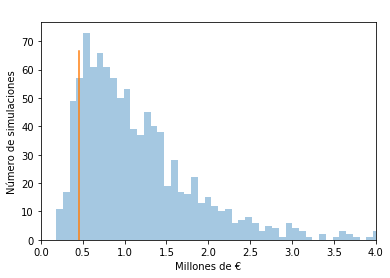

In [5]:

ax = sns.distplot(capitalEnd/1000000, kde=False, rug=False, bins=80); 
ax.set_title(' ')
ax.set_xlabel('Millones de €')
ax.set_ylabel('Número de simulaciones')
ax.set_xlim(0,4)

plt.plot([TOTAL_invested/1000000, TOTAL_invested/1000000], [0, Ns/15])


# What would be my monthly pension for given SWR?

We establish a SWR and we substratct inflation and taxes

/Users/raimon/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 10000)

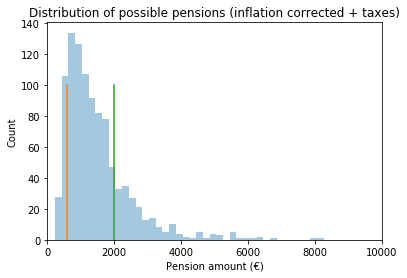

In [6]:
pension = (capitalEnd*pensionRate/100/12)*(1-tax)/(1+T*inflation/100)
p10 = np.percentile(pension, q=[10])


hist, bin_edges = np.histogram(pension, density=False)
ax = sns.distplot(pension, kde=False, rug=False)
ax.set_title('Distribution of possible pensions (inflation corrected + taxes)')
ax.set_xlabel('Pension amount (€)')
ax.set_ylabel('Count')
plt.plot([p10, p10], [0, Ns/10])
plt.plot([2000, 2000], [0, Ns/10])
ax.set_xlim(0,10000)

# Final Results

Summary of the results of this Monte Carlo simulation

In [9]:
print('Total Years: ' + str(T))
print('Number of simulation: ' + str(Ns))
print('Seed Money: ' + str(seedMoney)+'€')
print('Periodic Amount (monthly): ' + str(contriv/12)+'€')
print('Taxes: ' + str(tax*100)+'%')
print('Anual Inflation rate: ' + str(inflation)+'%')
print('Safe Withdrawal Rate (SWR): ' + str(pensionRate) + '%')
print('Rebalancing: ' + str(rebalancing))

print(' ')
print('_________Fund 1__________')
print('mu1: '     + str(mu1))
print('sig1: '    + str(sig1))
print('ogc1:'     + str(ogc1))
print('Balancing: ' + str(balancing))
print(' ')
print('_________Fund 2__________')
print('mu2: '     + str(mu2))
print('sig2: '    + str(sig2))
print('ogc2:'     + str(ogc2))
print('Balancing: ' + str(1-balancing))
print(' ')
print('Total invested: ' + str(np.round(TOTAL_invested)) + ' €')
print('Probabily our returns are larger than inflation: ' + str(np.round((np.size(np.where(capitalEndInf > TOTAL_invested))/Ns)*100)) + '%')
print('  ')
print('Savings within (10-90 percentile): ' + str(np.round(np.percentile(capitalEndInf, q=10))) + '€ and ' + str(np.round(np.percentile(capitalEndInf, q=90)))+'€')
print('Median Capital: ' + str(np.round(np.median(capitalEndInf))) + '€ ')
print('Pension between (10-90 percentile): ' + str(np.round(np.percentile(pension, q=10))) + '€ and ' + str(np.round(np.percentile(pension, q=90)))+'€')
print('Probability pension > 2000 Euros: ' + str(np.round((np.size(np.where(pension > 2000))/Ns)*100)) + '%')
print('Median Pension: ' + str(np.round(np.median(pension))))

Total Years: 25
Number of simulation: 1000
Seed Money: 50000€
Periodic Amount (monthly): 1000.0€
Taxes: 19.0%
Anual Inflation rate: 2.5%
Safe Withdrawal Rate (SWR): 3%
Rebalancing: True
 
_________Fund 1__________
mu1: 7
sig1: 18
ogc1:0.3
Balancing: 1.0
 
_________Fund 2__________
mu2: 5
sig2: 5
ogc2:0.2
Balancing: 0.0
 
Total invested: 459893.0 €
Probabily our returns are larger than inflation: 67.0%
  
Savings within (10-90 percentile): 286535.0€ and 1326528.0€
Median Capital: 605660.0€ 
Pension between (10-90 percentile): 580.0€ and 2686.0€
Probability pension > 2000 Euros: 21.0%
Median Pension: 1226.0
